In [1]:
import os
if "models" not in os.listdir("."):
    os.chdir("..")

In [3]:
%load_ext autoreload
%autoreload 2
import penzai
from penzai import pz
pz.ts.register_as_default()
pz.ts.register_autovisualize_magic()
pz.enable_interactive_context()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
from micrlhf.llama import LlamaTransformer
llama = LlamaTransformer.from_pretrained("models/gemma-2b.gguf", from_type="gemma", load_eager=True)

In [29]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("alpindale/gemma-2b")
tokenizer.padding_side = "right"

In [16]:
import json
save_path = "data/gemma-2b-explanations.json"
if os.path.exists(save_path):
    with open(save_path, "r") as f:
        index_explanations = {int(k): v for k, v in json.load(f).items()}

In [22]:
# from tqdm.auto import trange
# import requests
# max_neurons = 10_000
# try:
#     index_explanations
# except NameError:
#     index_explanations = {}
# step = 25
# for offset in trange(0, max_neurons, step):
#     if all(i in index_explanations for i in range(offset, offset + step)):
#         continue
#     gemma_neurons = requests.post("https://www.neuronpedia.org/api/neurons-offset", json={"modelId": "gemma-2b", "layer": "6-res-jb", "offset": offset}).json()
#     for n in gemma_neurons:
#         for e in n["explanations"]:
#             index_explanations[int(n["index"])] = e["description"]

In [23]:
if not os.path.exists(save_path):
    with open(save_path, "w") as f:
        json.dump(index_explanations, f)
else:
    existing = {int(k): v for k, v in json.load(open(save_path)).items()}
    existing.update(index_explanations)
    with open(save_path, "w") as f:
        json.dump(existing, f)

In [24]:
!mkdir -p models/sae
!wget -c 'https://huggingface.co/jbloom/Gemma-2b-Residual-Stream-SAEs/resolve/main/gemma_2b_blocks.6.hook_resid_post_16384_anthropic_fast_lr/sae_weights.safetensors?download=true' -O 'models/sae/gemma-jb-6.safetensors'
from safetensors import safe_open
with safe_open("models/sae/gemma-jb-6.safetensors", framework="numpy") as st:
    w_dec = st.get_tensor("W_dec")

/usr/local/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


--2024-06-26 23:05:07--  https://huggingface.co/jbloom/Gemma-2b-Residual-Stream-SAEs/resolve/main/gemma_2b_blocks.6.hook_resid_post_16384_anthropic_fast_lr/sae_weights.safetensors?download=true
Resolving huggingface.co (huggingface.co)... 108.156.211.95, 108.156.211.125, 108.156.211.90, ...
Connecting to huggingface.co (huggingface.co)|108.156.211.95|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/85/1c/851cab7a7e482c3ae3ab106128eb2a9086b354ced93766afbe639bb954bf89f8/16696a71f8b197c814cb959eb0ecf5ac4a7096963f2f6c526367daf95fc71792?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27sae_weights.safetensors%3B+filename%3D%22sae_weights.safetensors%22%3B&Expires=1719702307&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcxOTcwMjMwN319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzg1LzFjLzg1MWNhYjdhN2U0ODJjM2FlM2FiMTA2MTI4ZWIyYTkwODZiMzU

In [75]:
from micrlhf.utils.activation_manipulation import replace_activation, collect_activations
from micrlhf.sampling import sample
import jax
import jax.numpy as jnp
import numpy as np


def benchmark_vector(vector, tokens, model, positions, replacement_layer, layer=10):
    act_rep = collect_activations(replace_activation(model, vector, positions, layer=replacement_layer))
    logits, residuals = act_rep(tokens)
    return logits, residuals[layer].value


def tokens_to_inputs(tokens):
    token_array = jnp.asarray(tokens)
    token_array = jax.device_put(token_array, jax.sharding.NamedSharding(llama.mesh, jax.sharding.PartitionSpec("dp", "sp")))
    token_array = pz.nx.wrap(token_array, "batch", "seq").untag("batch").tag("batch")

    inputs = llama.inputs.from_basic_segments(token_array)
    return inputs


# def logits_to_loss(logits, tokens, answer_start, pad_token=32000):
#     logits = jax.nn.log_softmax(logits)

#     logits = logits[:, :-1]
#     logits = jnp.take_along_axis(logits, tokens[:, 1:, None], axis=-1).squeeze(-1)

#     mask = tokens[:, 1:] != pad_token

#     mask[:, :answer_start-1] = False

#     logits = logits * mask

#     return -logits.sum(axis=-1) / mask.sum(axis=-1)


MIN_SCALE = 0
MAX_SCALE = 50
REP_LAYER = 2
MAX_LENGTH = 64
PROMPT_TEMPLATE = 'What is the meaning of the word "X"? The meaning of the word "X" is "'
def pick_scale(feature, batch_size=64, min_scale=MIN_SCALE, max_scale=MAX_SCALE, layer=REP_LAYER):
    scales = np.linspace(min_scale, max_scale, batch_size)
    vector = feature[None, :] * jnp.array(scales)[:, None]
    text = [PROMPT_TEMPLATE for _ in range(batch_size)]
    tokenized = tokenizer(text, return_tensors="np", padding="max_length", max_length=64, truncation=True)
    tokens = tokenized["input_ids"]
    inputs = tokens_to_inputs(tokens)
    positions = [i for i, a in enumerate(tokenizer.encode(PROMPT_TEMPLATE)) if tokenizer.decode([a]) == "X"]
    logits, residuals = benchmark_vector(vector, inputs, llama, positions, layer)
    logits = logits.unwrap("batch", "seq", "vocabulary")
    entropies = -jnp.sum(jax.nn.log_softmax(logits) * jnp.exp(jax.nn.log_softmax(logits)), axis=-1)
    entropy_first = entropies[:, -1]
    resid = residuals.unwrap("batch", "seq", "embedding")[:, -1]
    resid_cos_feature = resid @ feature / jnp.linalg.norm(resid) / jnp.linalg.norm(feature)
    resid_cos_feature = resid_cos_feature - resid_cos_feature[0]
    entropy_first = entropy_first - entropy_first[0]
    return scales, entropy_first, resid_cos_feature

def generate_explanations(feature, batch_size=64, min_scale=MIN_SCALE, max_scale=MAX_SCALE, layer=REP_LAYER):
    scales = np.linspace(min_scale, max_scale, batch_size)
    vector = feature[None, :] * jnp.array(scales)[:, None]
    positions = [i for i, a in enumerate(tokenizer.encode(PROMPT_TEMPLATE)) if tokenizer.decode([a]) == "X"]
    act_rep = replace_activation(llama, vector, positions, layer=layer)
    completions, _ = sample(act_rep, tokenizer,
                         PROMPT_TEMPLATE, batch_size=batch_size,
                         do_sample=True, max_seq_len=MAX_LENGTH,
                         return_only_completion=True, return_model=False,
                         verbose=False)
    return list(zip(scales, completions))

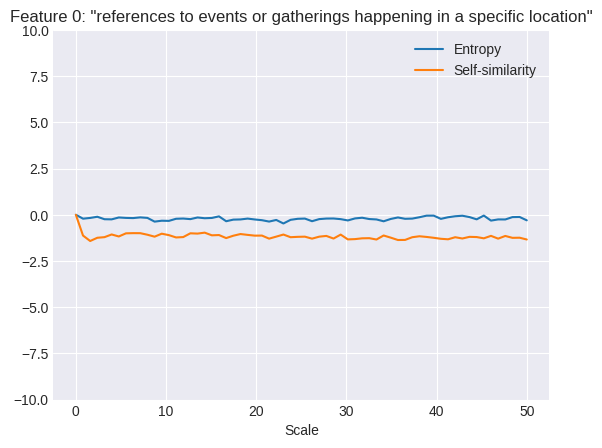

KeyboardInterrupt: 

In [76]:
from matplotlib import pyplot as plt


plt.style.use("seaborn-v0_8-darkgrid")
for i, e in index_explanations.items():
    scales, entropy, selfsim = pick_scale(w_dec[i])
    plt.plot(scales, entropy, label=f"Entropy")
    plt.plot(scales, selfsim * 2000, label=f"Self-similarity")
    plt.title(f"Feature {i}: \"{e}\"")
    plt.xlabel("Scale")
    plt.ylim(-10, 10)
    plt.legend()
    plt.show()
    scale_idx = np.argmax(selfsim)
    highest = selfsim[scale_idx]
    scale = scales[scale_idx]
    scale = scales[scale_idx]
    display(generate_explanations(w_dec[i]))